In [1]:
import os, csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# merge csv
train_path = 'datasets/train.csv'
test_x_path = 'datasets/test.csv'

train_df = pd.read_csv(train_path)

In [3]:
# pipeline
def pipeline(df):

    to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id']
    df = df.drop(columns=to_drop)
    
    for column in df.columns:
        if df[column].dtype == 'float64':
            # Handle numeric columns (replace NaN with mean)
            df[column].fillna(df[column].mean(), inplace=True)
        elif df[column].dtype == 'object':
            # Handle categorical columns (replace NaN with mode)
            df[column].fillna(df[column].mode()[0], inplace=True)

    # Create a dictionary to store the mappings
    columns_to_map = {}
    
    # Define the columns to process
    columns = ["ethnicity", "gender", "icu_admit_source", "icu_stay_type", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem"]
    
    # Iterate through the columns and create mappings
    for column in columns:
        unique_values = df[column].unique()
        np.random.shuffle(unique_values)  # Shuffle the unique values
        mapping = {value: index for index, value in enumerate(unique_values)}
        columns_to_map[column] = mapping
    
    # Apply the mappings to the DataFrame
    for column, mapping in columns_to_map.items():
        df[column] = df[column].map(mapping)
    
    return df


train_df = pipeline(train_df)

In [4]:
X = train_df.drop('hospital_death', axis=1)
y = train_df['hospital_death']

In [5]:
# 5-fold cross validation
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, random_state=42, shuffle=True)

final_f1 = 0
final_auroc = 0

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
    RF_model.fit(X_train, y_train)
    y_pred = RF_model.predict(X_test)
    print('==================================================')
    print(classification_report(y_test, y_pred))
    final_f1 += classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score']
    final_auroc += roc_auc_score(y_test, y_pred)

print('')
print('')
print('Final F1-score: ', final_f1/5)
print('Final AUROC: ', final_auroc/5)
print('')
print('Training on all data...')

# Train Final Model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X, y)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9375
           1       0.72      0.25      0.37       897

    accuracy                           0.93     10272
   macro avg       0.82      0.62      0.66     10272
weighted avg       0.91      0.93      0.91     10272

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      9422
           1       0.72      0.26      0.38       850

    accuracy                           0.93     10272
   macro avg       0.83      0.62      0.67     10272
weighted avg       0.92      0.93      0.91     10272

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9407
           1       0.66      0.25      0.36       865

    accuracy                           0.93     10272
   macro avg       0.80      0.62      0.66     10272
weighted avg       0.91      0.93      0.91     10272

              preci

RandomForestClassifier(random_state=42)

In [9]:
# predict and submit
test_df = pd.read_csv(test_x_path)
test_df_ = pipeline(test_df)

# predict
y_pred = RF_model.predict(test_df_)
# write to csv: need 'encounter_id' and 'pred'
with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['encounter_id', 'hospital_death'])
    for i in range(len(y_pred)):
        writer.writerow([test_df['encounter_id'][i], y_pred[i]])

<Axes: xlabel='Feature Importance', ylabel='Features'>

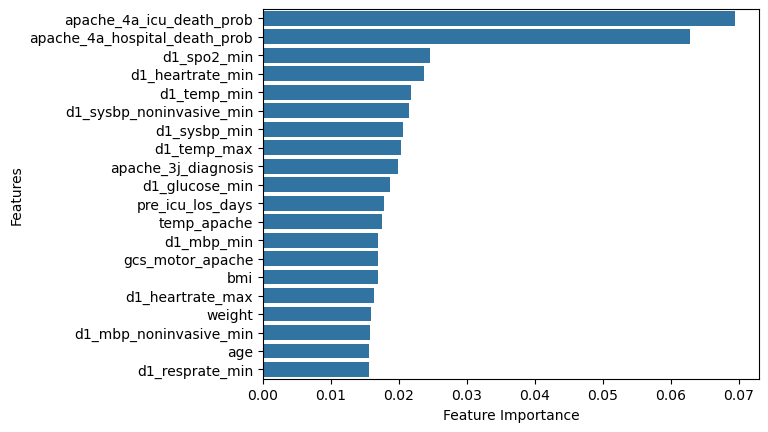

In [7]:
# Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.Series(RF_model.feature_importances_, index=X.columns).sort_values(ascending=False)
# assign x label 'Feature Importance' and y label 'Features'
plt.xlabel('Feature Importance')
plt.ylabel('Features')
# Creating a bar plot in whitegrid style
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])

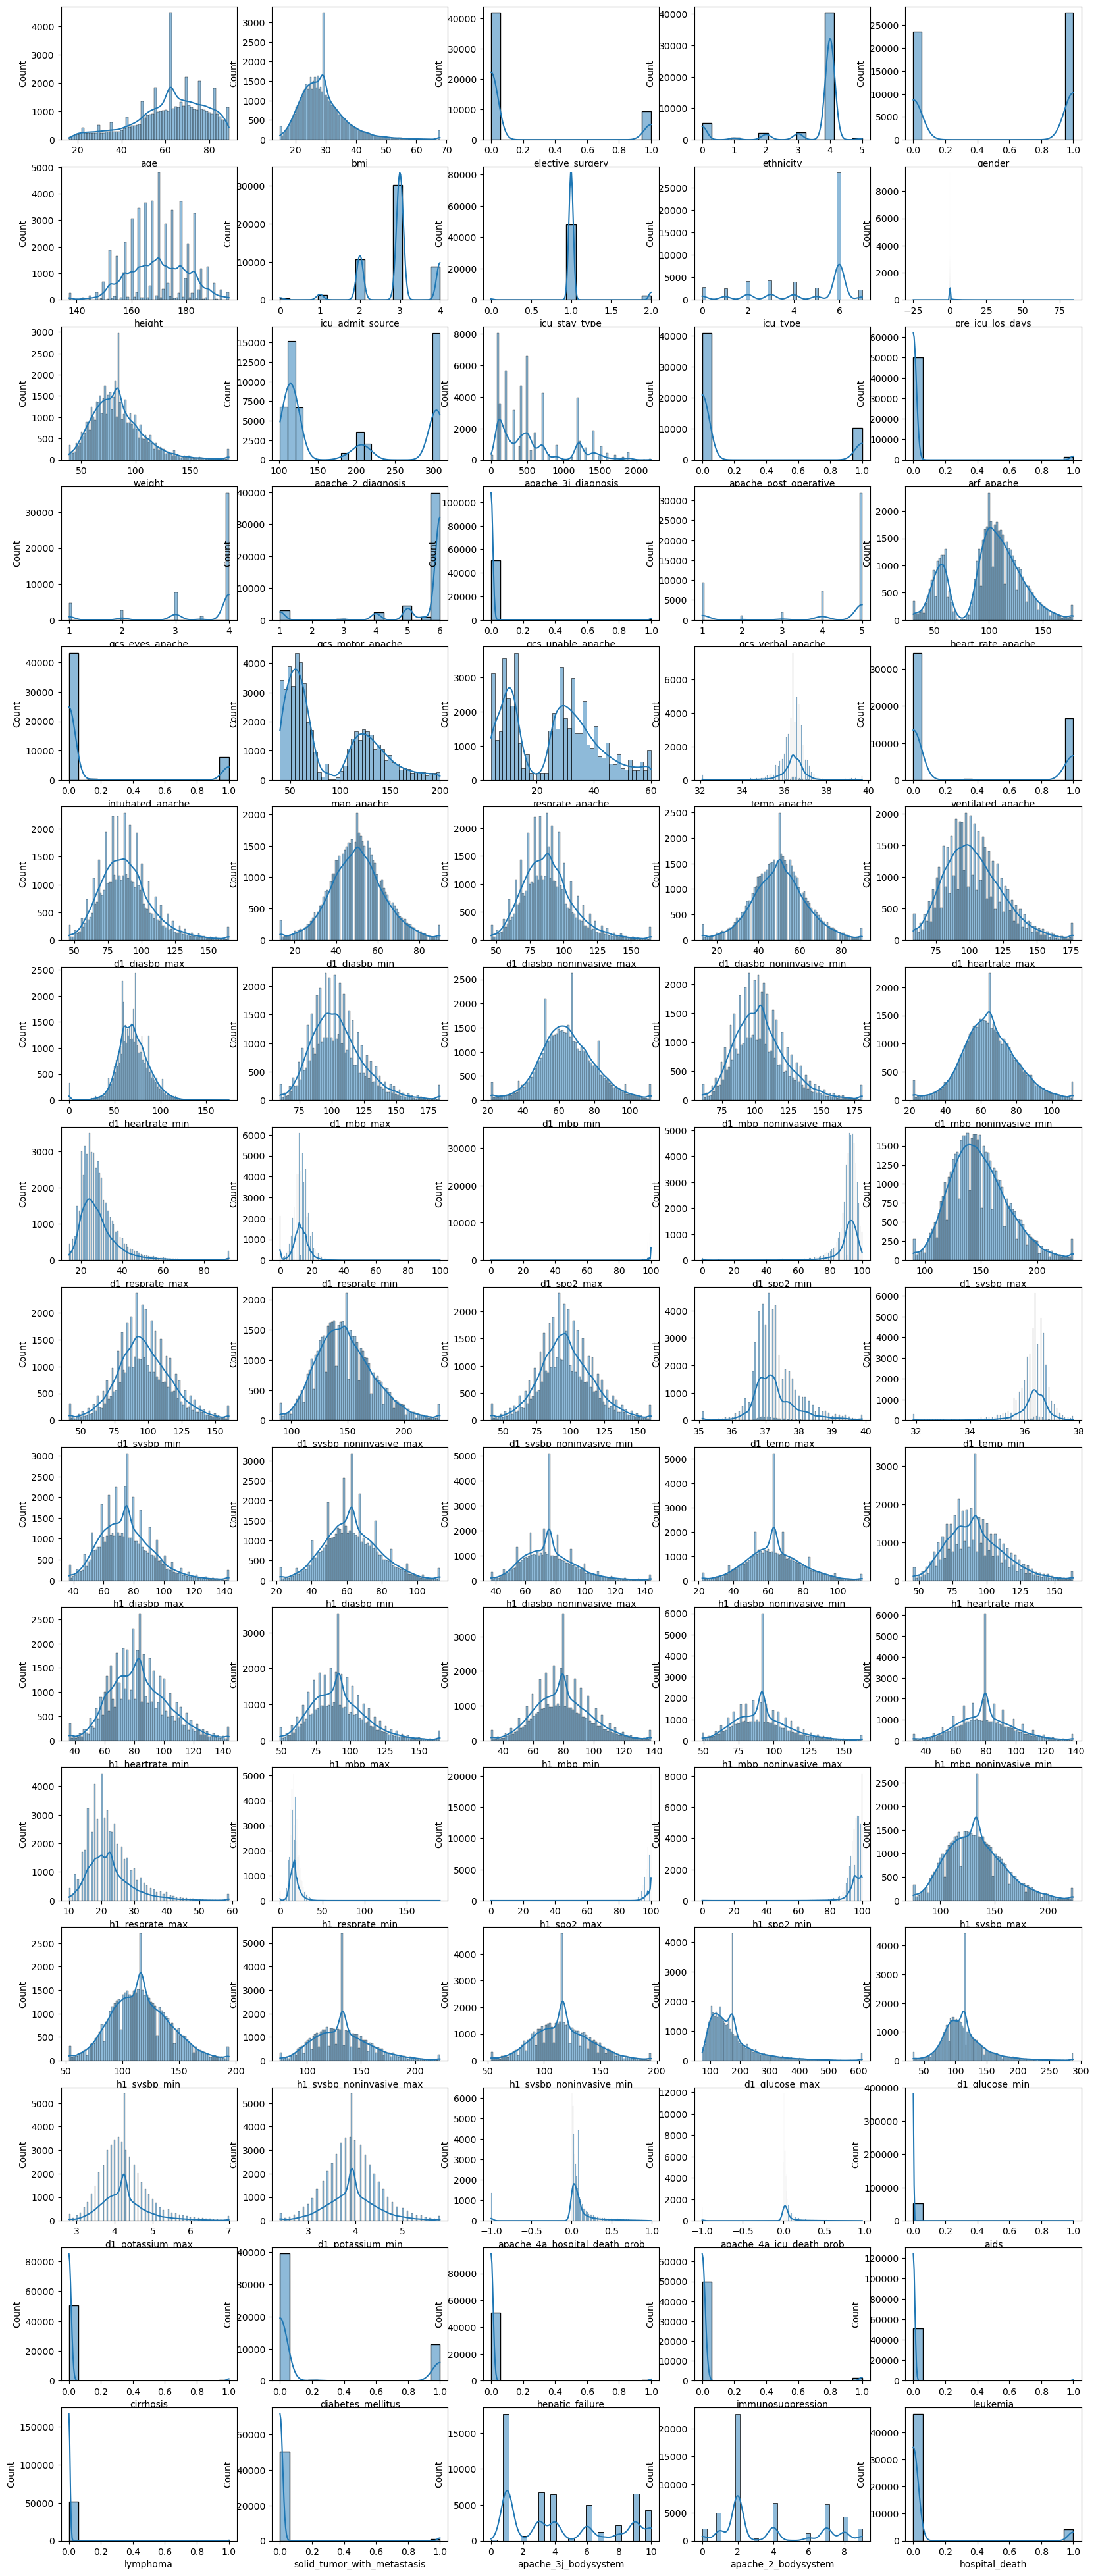

In [8]:
# draw histplot of all columns in one figure
bias = 0
figure, axes = plt.subplots(16, 5, figsize=(20, 50))
for i in range(16):
    for j in range(5):
        try:
            sns.histplot(ax=axes[i, j], data=train_df[train_df.columns[i*5+j]], kde=True)
        except:
            bias += 1
            sns.histplot(ax=axes[i, j], data=train_df[train_df.columns[i*5+j+bias]], kde=True)
